# Import Semua Library yang Dibutuhkan
Pada tahap awal, kita mengimpor semua pustaka (library) yang diperlukan. Mengumpulkan semua impor di awal adalah praktik terbaik agar kode lebih rapi dan mudah dikelola.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:

# path ke dataset asli (folder per kelas)
dataset_dir = "data"
output_dir = "dataset_split"

# buat folder output
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)

    # buat subfolder kelas di setiap split
    for kelas in os.listdir(dataset_dir):
        os.makedirs(os.path.join(split_dir, kelas), exist_ok=True)

# loop setiap kelas
for kelas in os.listdir(dataset_dir):
    kelas_dir = os.path.join(dataset_dir, kelas)
    images = os.listdir(kelas_dir)
    random.shuffle(images)

    total = len(images)
    train_count = int(0.8 * total)
    val_count = int(0.1 * total)

    train_files = images[:train_count]
    val_files = images[train_count:train_count + val_count]
    test_files = images[train_count + val_count:]

    # copy file ke masing-masing folder
    for f in train_files:
        shutil.copy(os.path.join(kelas_dir, f), os.path.join(output_dir, "train", kelas, f))
    for f in val_files:
        shutil.copy(os.path.join(kelas_dir, f), os.path.join(output_dir, "val", kelas, f))
    for f in test_files:
        shutil.copy(os.path.join(kelas_dir, f), os.path.join(output_dir, "test", kelas, f))

print("✅ Dataset berhasil dibagi menjadi Train/Val/Test (80/10/10) secara proporsional")


# Konfigurasi Path, Parameter, dan Nama Model
Di sel ini, kita mengatur semua variabel global yang akan digunakan di seluruh notebook, seperti path ke dataset, ukuran gambar, dan nama file untuk model yang akan kita simpan. Dengan cara ini, jika Anda ingin mengubah sesuatu (misalnya, nama model untuk eksperimen baru), Anda hanya perlu mengubahnya di satu tempat.

In [ ]:
# Path ke dataset yang sudah di sorting
BASE_PATH = 'dataset_split'
train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

# Cek dan tampilkan struktur direktori
def print_directory_structure(path, indent=""):
    if os.path.exists(path):
        print(f"{indent}📂 {os.path.basename(path)}")
        try:
            for item in os.listdir(path):
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    print_directory_structure(item_path, indent + "  ")
                else:
                    print(f"{indent}  📄 {item}")
        except Exception as e:
            print(f"{indent}  ❌ Error reading directory: {str(e)}")
    else:
        print(f"{indent}❌ Path tidak ditemukan: {path}")

print("Struktur Dataset:")
print_directory_structure(BASE_PATH)

# Konfigurasi model
MODEL_NAME = 'final_dokter_cabai.h5'
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100

# Deteksi kelas dari direktori training
if os.path.exists(train_dir):
    CLASSES = sorted(os.listdir(train_dir))
    print(f"\nKelas yang terdeteksi: {CLASSES}")
    print(f"Jumlah kelas: {len(CLASSES)}")
else:
    print("\nWarning: Training directory tidak ditemukan!")
    CLASSES = []

Struktur Dataset:
📂 dataset_split
  📂 test
    📂 healthy
      📄 Healthy Leaf00020.JPG
      📄 Healthy Leaf00096.JPG
      📄 Healthy Leaf00104.JPG
      📄 Healthy Leaf00116.JPG
      📄 Healthy Leaf00177.JPG
      📄 Healthy Leaf00193.JPG
      📄 Healthy Leaf00206.JPG
      📄 IMG_20210421_090934_jpg.rf.9b3fea5d9ab3c0e9c76a6f24ff353fc2.jpg
      📄 IMG_20210421_091233_jpg.rf.9d866303c1745899abc8da531f604084.jpg
      📄 IMG_20210421_091927_jpg.rf.0062a8b03036f1eb159730770acc62da.jpg
      📄 IMG_20210421_093648_jpg.rf.d3b374af3ab8c071208055480f722f3d.jpg
      📄 sehat-117-_jpg.rf.9f826a63a83d2ccc90b2f2e3a7f44d4a.jpg
    📂 leaf curl
      📄 Curl Virus00137.JPG
      📄 Curl Virus00171.JPG
      📄 Curl Virus00172.JPG
      📄 Curl Virus00231.JPG
      📄 Curl Virus00262.JPG
      📄 Curl Virus00276.JPG
      📄 Curl Virus00358.JPG
      📄 Curl Virus00384.JPG
      📄 Curl Virus00388.JPG
      📄 Curl Virus00410.JPG
      📄 download (9).jpg
      📄 images (19)a.jpg
      📄 images (21)a.jpg
      📄 ima

# Persiapan Data (Data Augmentation & Generators)
Langkah ini sangat krusial. Kita akan menyiapkan "pipa" data menggunakan ImageDataGenerator. Untuk data training, kita akan menerapkan augmentasi data (memutar, zoom, flip) untuk membuat model lebih tangguh dan mencegah overfitting. Untuk data validasi dan test, kita hanya melakukan pra-pemrosesan tanpa augmentasi.

In [3]:
# Siapkan data augmentation untuk training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # Reduced from 40 to avoid extreme rotations
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validasi dan testing, hanya gunakan preprocessing
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

try:
    print("Memuat data training...")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=seed  
    )
    
    print("\nMemuat data validasi...")
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print("\nMemuat data testing...")
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print("\nJumlah sampel:")
    print(f"Training: {train_generator.samples}")
    print(f"Validasi: {val_generator.samples}")
    print(f"Testing: {test_generator.samples}")
    
except FileNotFoundError as e:
    print(f"Error: Directory tidak ditemukan. Pastikan struktur folder benar:\n{str(e)}")
except Exception as e:
    print(f"Error saat memuat data: {str(e)}")

Memuat data training...
Found 443 images belonging to 5 classes.

Memuat data validasi...
Found 54 images belonging to 5 classes.

Memuat data testing...
Found 59 images belonging to 5 classes.

Jumlah sampel:
Training: 443
Validasi: 54
Testing: 59


In [4]:
class_indices = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: np.float64(1.0068181818181818), 1: np.float64(0.7637931034482759), 2: np.float64(1.1215189873417721), 3: np.float64(1.1075), 4: np.float64(1.1075)}


# Membangun Arsitektur Model (Transfer Learning MobileNetV2)
Di sini kita membangun "otak" dari sistem kita. Kita menggunakan Transfer Learning dengan model MobileNetV2 yang sudah terlatih pada ImageNet. Kita "membekukan" lapisan dasar MobileNetV2 dan hanya melatih beberapa lapisan baru di atasnya.

In [5]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
 )
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Melatih Model
Sekarang saatnya melatih model kita. Kita menggunakan dua callbacks penting: EarlyStopping dan ModelCheckpoint untuk mencegah overfitting dan menyimpan model terbaik selama training.

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  verbose=1, 
                  restore_best_weights=True),
    ModelCheckpoint(MODEL_NAME, 
                    monitor='val_loss',  # <-- Menggunakan val_loss juga
                    save_best_only=True, 
                    mode='min')          # <-- Mode diubah ke 'min' karena loss lebih baik jika lebih kecil
]
checkpoint_cb = ModelCheckpoint(
    MODEL_NAME,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_cb, earlystop_cb],  # <- tambahkan ini
    verbose=1
 )

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2258 - loss: 2.0949
Epoch 1: val_accuracy improved from -inf to 0.48148, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 461ms/step - accuracy: 0.2269 - loss: 2.0886 - val_accuracy: 0.4815 - val_loss: 1.4627
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3728 - loss: 1.5741
Epoch 2: val_accuracy improved from 0.48148 to 0.62963, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.3745 - loss: 1.5712 - val_accuracy: 0.6296 - val_loss: 1.1676
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5003 - loss: 1.3096
Epoch 3: val_accuracy improved from 0.62963 to 0.72222, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.5004 - loss: 1.3084 - val_accuracy: 0.7222 - val_loss: 0.9511
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5785 - loss: 1.1493
Epoch 4: val_accuracy improved from 0.72222 to 0.75926, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.5794 - loss: 1.1482 - val_accuracy: 0.7593 - val_loss: 0.8143
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6022 - loss: 1.0358
Epoch 5: val_accuracy improved from 0.75926 to 0.81481, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.6036 - loss: 1.0343 - val_accuracy: 0.8148 - val_loss: 0.7201
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6751 - loss: 0.9151
Epoch 6: val_accuracy did not improve from 0.81481
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.6744 - loss: 0.9153 - val_accuracy: 0.8148 - val_loss: 0.6424
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7131 - loss: 0.8206
Epoch 7: val_accuracy did not improve from 0.81481
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.7125 - loss: 0.8213 - val_accuracy: 0.8148 - val_loss: 0.5848
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7292 - loss: 0.7633
Epoch 8: val_accuracy did not improve from 0.81481
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.7290 - loss: 0.7631 - val_accuracy: 0.8148 - val_loss: 0.5386
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7672 - loss: 0.6884
Epoch 9: val_accuracy improved 

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7660 - loss: 0.6894 - val_accuracy: 0.8333 - val_loss: 0.4980
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7590 - loss: 0.6999
Epoch 10: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.7587 - loss: 0.6997 - val_accuracy: 0.8333 - val_loss: 0.4641
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7757 - loss: 0.6220
Epoch 11: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7758 - loss: 0.6219 - val_accuracy: 0.8148 - val_loss: 0.4503
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8006 - loss: 0.5809
Epoch 12: val_accuracy did not improve from 0.83333
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7999 - loss: 0.5825 - val_accuracy: 0.8333 - val_loss: 0.4263
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7856 - loss: 0.6273
Epoch 13: val_accuracy i

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.7858 - loss: 0.6260 - val_accuracy: 0.8519 - val_loss: 0.4003
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7495 - loss: 0.6415
Epoch 14: val_accuracy did not improve from 0.85185
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7507 - loss: 0.6392 - val_accuracy: 0.8333 - val_loss: 0.3916
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7797 - loss: 0.5376
Epoch 15: val_accuracy improved from 0.85185 to 0.87037, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.7803 - loss: 0.5375 - val_accuracy: 0.8704 - val_loss: 0.3781
Epoch 16/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8081 - loss: 0.4796
Epoch 16: val_accuracy did not improve from 0.87037
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8087 - loss: 0.4797 - val_accuracy: 0.8519 - val_loss: 0.3677
Epoch 17/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7868 - loss: 0.5191
Epoch 17: val_accuracy improved from 0.87037 to 0.88889, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.7873 - loss: 0.5190 - val_accuracy: 0.8889 - val_loss: 0.3299
Epoch 18/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8164 - loss: 0.4928
Epoch 18: val_accuracy did not improve from 0.88889
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.8165 - loss: 0.4930 - val_accuracy: 0.8889 - val_loss: 0.3272
Epoch 19/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8375 - loss: 0.4867
Epoch 19: val_accuracy improved from 0.88889 to 0.92593, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.8377 - loss: 0.4860 - val_accuracy: 0.9259 - val_loss: 0.2960
Epoch 20/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8458 - loss: 0.4242
Epoch 20: val_accuracy did not improve from 0.92593
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.8461 - loss: 0.4239 - val_accuracy: 0.9259 - val_loss: 0.2839
Epoch 21/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8181 - loss: 0.5046
Epoch 21: val_accuracy improved from 0.92593 to 0.94444, saving model to coba_40.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8181 - loss: 0.5047 - val_accuracy: 0.9444 - val_loss: 0.2819
Epoch 22/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8463 - loss: 0.4439
Epoch 22: val_accuracy did not improve from 0.94444
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8458 - loss: 0.4436 - val_accuracy: 0.9259 - val_loss: 0.2662
Epoch 23/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8614 - loss: 0.3868
Epoch 23: val_accuracy did not improve from 0.94444
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.8612 - loss: 0.3881 - val_accuracy: 0.9259 - val_loss: 0.2630
Epoch 24/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8566 - loss: 0.4286
Epoch 24: val_accuracy did not improve from 0.94444
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.8556 - loss: 0.4291 - val_accuracy: 0.9259 - val_loss: 0.2558
Epoch 25/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8503 - loss: 0.4234
Epoch 25: val_accuracy d

# Visualisasi Hasil Training (Grafik Akurasi & Loss)
Setelah training selesai, kita harus memvisualisasikan hasilnya. Grafik ini membantu kita memahami bagaimana performa model selama proses training dan validasi.

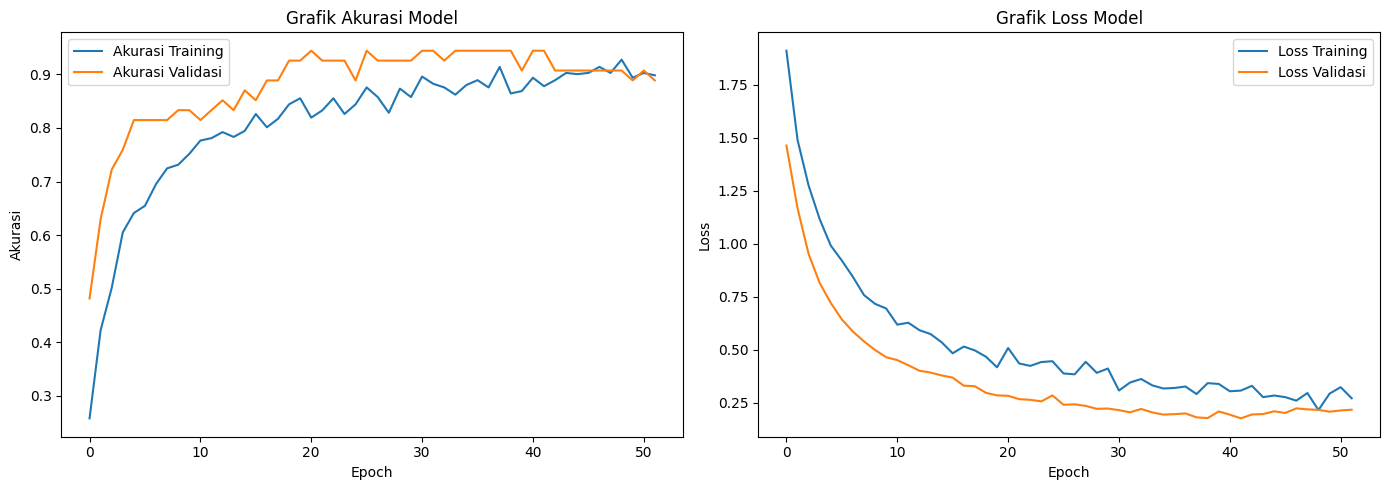

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Akurasi Training')
plt.plot(val_acc, label='Akurasi Validasi')
plt.title('Grafik Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss Training')
plt.plot(val_loss, label='Loss Validasi')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluasi Final pada Data Test
Kita memuat model terbaik yang disimpan oleh ModelCheckpoint dan mengujinya pada test set—data yang sama sekali belum pernah dilihat model selama training.

In [8]:
best_model = load_model(MODEL_NAME)
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)
print(f"Akurasi pada data test: {test_acc:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - accuracy: 0.8864 - loss: 0.3257
Akurasi pada data test: 83.05%


# Analisis Mendalam - Confusion Matrix & Classification Report
Akurasi saja tidak cukup. Confusion Matrix dan Classification Report menunjukkan secara detail di mana model kita membuat kesalahan dan seberapa baik model mengenali tiap kelas.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step

Laporan Klasifikasi untuk Data Test:

              precision    recall  f1-score   support

     healthy       0.92      1.00      0.96        12
   leaf curl       0.88      0.94      0.91        16
   leaf spot       1.00      0.55      0.71        11
    whitefly       0.67      0.80      0.73        10
   yellowish       0.73      0.80      0.76        10

    accuracy                           0.83        59
   macro avg       0.84      0.82      0.81        59
weighted avg       0.85      0.83      0.83        59



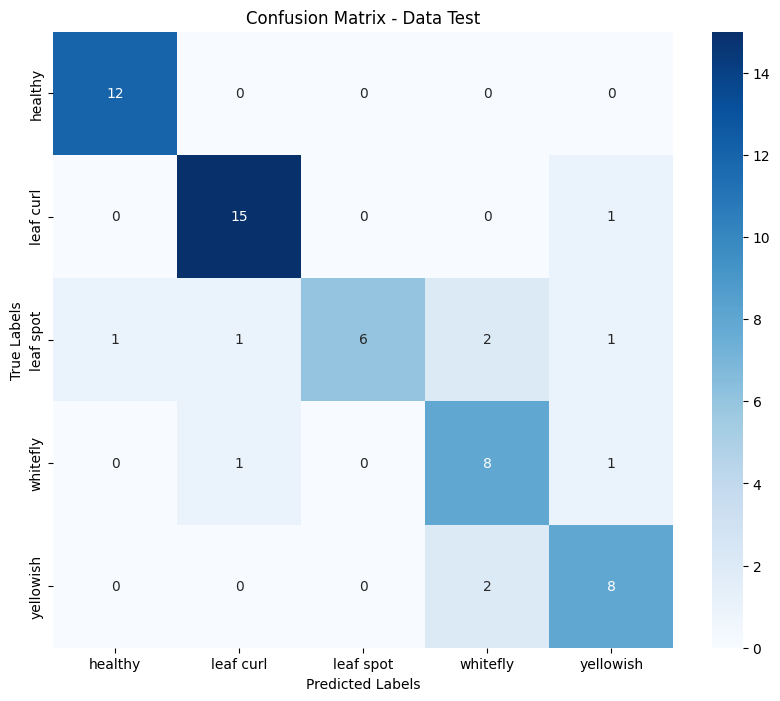

In [11]:
import seaborn as sns

steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
Y_pred = best_model.predict(test_generator, steps=steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("\nLaporan Klasifikasi untuk Data Test:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Data Test')
plt.show()
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


# Uji Coba Prediksi pada Gambar Tunggal
Terakhir, kita buat fungsi untuk menguji model seperti pada aplikasi nyata: memasukkan satu gambar dan melihat apa hasil prediksinya.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


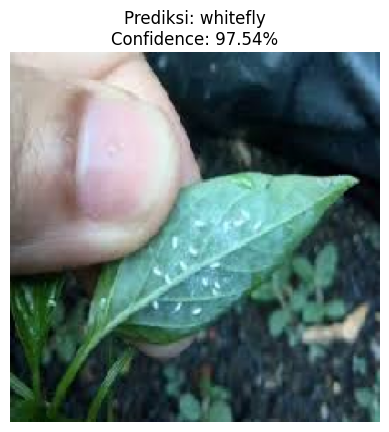

('whitefly', np.float32(0.97536397))

In [10]:
def predict_single_image(img_path, model, class_names, threshold=0.5):
    try:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        pred = model.predict(img_array)
        class_idx = np.argmax(pred[0])
        confidence = pred[0][class_idx]
        plt.imshow(img)
        if confidence < threshold:
            predicted_class = "Tidak Dikenali (Confidence Rendah)"
            title_text = f'Prediksi: {predicted_class}\nConfidence: {confidence:.2%}'
        else:
            predicted_class = class_names[class_idx]
            title_text = f'Prediksi: {predicted_class}\nConfidence: {confidence:.2%}'
        plt.title(title_text)
        plt.axis('off')
        plt.show()
        return predicted_class, confidence
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di path '{img_path}'")
        return None, None
    except Exception as e:
        print(f"Terjadi error saat memproses gambar: {e}")
        return None, None

# Contoh penggunaan:
test_image_path = 'image.png'  # Ganti dengan path gambar yang ingin diuji
predict_single_image(test_image_path, best_model, CLASSES, threshold=0.5)